In [5]:
import requests
import re
import pandas as pd
import wikipedia
import pprint

# Part 1 Collect all Machine Learing and Business Software categories

In [5]:
# Make a suite of functions to get articles based on categories and their respective text in dataframe
def generate_category(category):
    '''
    format a category for insertion in to a wikipedia api call
    '''
    category = re.sub('\s','_',category)
    return category

In [6]:
def generate_query(category):
    '''
    Format an api call for requests
    '''
    query = """
            http://en.wikipedia.org/w/api.php?
            action=query&
            format=json&
            list=categorymembers&
            cmlimit=max&
            explaintext=True&
            cmtitle=Category:{} 
            
            """.format(generate_category(category))
    query = re.sub('\s','',query)
    return query

In [7]:
def execute_category_query(category):
    '''
    Executes a category qeury and returns a 
    DataFrame of the category members
    '''
    
    r = requests.get(generate_query(category))
    response = r.json()
    return pd.DataFrame(response['query']['categorymembers'])

In [8]:
def remove_category(category):
    category = re.sub('Category:','',category)
    return category

In [6]:
def get_all_pages_rec(category, level):
    category_df = execute_category_query(category)
    
    if category_df.shape == (0, 0):
        return None
    pages_list = []
    
    
    category_mask = category_df['title'].str.contains('Category:')
    pages_df = category_df[~category_mask]
    pages_list.append(pages_df)
    
    categories = category_df[category_mask]['title']\
                            .str.replace('Category:','').tolist()
    if len(categories) > 0:
        for cat in categories:
            if level>0:
                level-=1
                pages_list.append(get_all_pages_rec(cat, level-1))
                level+=1
    pages_df = pd.concat(pages_list)
    pages_df.reset_index(drop=True)
    return pages_df

In [9]:
def get_whole_category(category, level):
    df = get_all_pages_rec(category, level)
    df = df.drop_duplicates().reset_index(drop=True)
    df['category_id'] = category
    return df

Use this suite of functions to get all the Wikipedia articles in the 'Machine learning' and 'Business software' category

In [8]:
ml_df=get_whole_category('Machine learning', 5)
ml_df.shape

(1107, 4)

In [9]:
bs_df=get_whole_category('Business software', 2)
bs_df.shape

(1550, 4)

In [10]:
pages_df=pd.concat([ml_df, bs_df], axis=0, ignore_index=True)

In [11]:
pages_df=pages_df.drop(["ns"], axis=1)

Define a text cleaner that formats text to lowercase alpha-numeric characters and removes LateX formatting that may arise from mathematical equations within the articles.

We will use this cleaner when we query text from articles using the Wikipedia API

In [86]:
def cleaner(message):
    message = re.sub('[.,\/#!$%\^&\*;:{}\+=<>_`~()]', ' ', message)
    message = re.sub('[^a-z0-9 ]','', message.lower())
    message = re.sub('displaystyle',' ', message)
    message = re.sub('\d+',' NUMBER ',message)
    message = re.sub('\s+',' ',message)
    return message

In [80]:
def get_text(page_id):
    try:
        if type(page_id) == int:
            page = wikipedia.WikipediaPage(pageid=str(page_id), preload = True)
            text= cleaner(page.content)
        else:
            page = wikipedia.WikipediaPage(title=page_id, preload = True)
            text= cleaner(page.content)
    except:
        text='failed'
    return text

In [16]:
pages_df["text"]=pages_df['pageid'].apply(get_text)

In [222]:
pages_df.sample(20)

NameError: name 'pages_df' is not defined

In [22]:
pages_df.to_pickle("pages_df.p")

In [275]:
df = pd.read_pickle("pages_df.p")

In [276]:
#I unforutnately pickled my dataframe before cleaning a bit further
# I need to remove entries where my text reader failed

mask1=df['text'].map(len) !=6
failed_mask=df['text'].str.contains("failed") == False

In [277]:
df=df[mask1 & failed_mask]

In [278]:
df.shape

(2478, 4)

In [ ]:
# And title entries that begine with Portal: and User:

In [279]:
portal_mask=df['title'].str.contains("Portal:") == False
user_mask=df['title'].str.contains("User:") == False

In [280]:
df=df[user_mask]
df=df[portal_mask]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [301]:
df.shape

(2469, 4)

In [300]:
df = df.reset_index(drop=True)

In [ ]:
###### Load this datafram into a postgres database

In [10]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor

In [255]:
from sqlalchemy import create_engine
from sqlalchemy import insert, select
from sqlalchemy import Table, Column, MetaData, Integer, String

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [256]:
engine = create_engine("postgresql://postgres@postgres/postgres")

In [257]:
connection=engine.connect()

In [258]:
print(engine.table_names())

['pages', 'text']


In [259]:
pages=df.to_sql("pages", con=engine, if_exists="replace", index=False)

In [261]:
metadata=MetaData()

In [262]:
#build pages table from df
pages= Table('pages', metadata, autoload=True, autoload_with=engine)


In [263]:
pages.columns.keys()

['pageid', 'title', 'category_id', 'text']

In [264]:
#build text table
text = Table('text', metadata,
             Column('pageid', Integer()),
             Column('text', String(), default='NaN')
)


In [265]:
text.columns.keys()

['pageid', 'text']

In [267]:
metadata.create_all(engine)


# Part 2 Search 
Use Latent Semantic Analysis to return top 5 related articles given a search term query

Algorithm:
1. Vectorize all the text from the Wikipedia articles we collected
2. Put those tokens in a document term matrix
3. Reduce the dimensionality of the document term matrix
4. Given a new search term vectorize and fit vector into a document term matrix in the same way
5. Use cosine similarities between this DTM and the master DTM to find the nearest articles

Vectorize text from Machine Learning and Business Software articles using a TfidfVectorizer.
Using a TfidfVectorizer will downweight the importance of words that appear across articles

In [ ]:
text=df['text']
tfidf_vectorizer = TfidfVectorizer(min_df = 2, stop_words = 'english', ngram_range=(2, 5))
document_term_matrix = tfidf_vectorizer.fit_transform(text)

I got the best results using a min_df of 2 and n_gram range from 2 to 5

### Singular Value Decomposition

We can use SVD as a dimensionality reduction technique so our document term matrix will be represented with the most important tokens

In [303]:
# Truncated the document term matrix to 300 components; fit tranform document term matrix
SVD = TruncatedSVD(300)
latent_semantic_analysis = SVD.fit_transform(document_term_matrix)

### Sample Search

In [304]:
#sample search term
search_term="artficial intelligence"

In [305]:
#vectorize the term the same way
search_term_vec = tfidf_vectorizer.transform([search_term])
search_term_lsa = SVD.transform(search_term_vec)

In [306]:
#generate cosine similarities between search term vector and our master latent semantic analysis vector
cosine_similarities = latent_semantic_analysis.dot(search_term_lsa.T).ravel()

In [307]:
#get the indices of the top 5 most related terms
cosine_similarities.argsort()[:-6:-1]

array([2468,  819,  826,  825,  824])

In [308]:
[df.loc[i]['title'] for i in cosine_similarities.argsort()[:-6:-1]]

['XDB Enterprise Server',
 'Inverted pendulum',
 'Bernoulli scheme',
 'Baum–Welch algorithm',
 'Algorithmic composition']

### This search function replicates the process above

In [309]:
def search(search_term):
    
    search_term_vec = tfidf_vectorizer.transform([search_term])
    search_term_lsa = SVD.transform(search_term_vec)
    
    cosine_similarities = latent_semantic_analysis.dot(search_term_lsa.T).ravel()
    top_five_index=cosine_similarities.argsort()[:-6:-1]
    top_five=[df.loc[i]['title'] for i in top_five_index]
    
    return top_five

In [310]:
test_terms=["artficial intelligence", "Microsoft Excel", "Naive Bayes", "Oracle", "Alan Turing", "Bill Gates"]
results={term: search(term) for term in test_terms}

In [311]:
pprint.pprint(results)

{'Alan Turing': ['ELIZA',
                 'Zoubin Ghahramani',
                 'Melomics',
                 'Algorithmic composition',
                 'IBM 709/90 9PAC'],
 'Bill Gates': ['XDB Enterprise Server',
                'Inverted pendulum',
                'Bernoulli scheme',
                'Baum–Welch algorithm',
                'Algorithmic composition'],
 'Microsoft Excel': ['Jedox',
                     'Palo (OLAP database)',
                     'Pivot chart',
                     'SuperCalc',
                     'Gnumeric'],
 'Naive Bayes': ['Averaged one-dependence estimators',
                 'Naive Bayes classifier',
                 'Multiclass classification',
                 'Language model',
                 'Predictive Model Markup Language'],
 'Oracle': ['XDB Enterprise Server',
            'Inverted pendulum',
            'Bernoulli scheme',
            'Baum–Welch algorithm',
            'Algorithmic composition'],
 'artficial intelligence': ['XDB Enter

# Part 3 Predictive Model for categorizing Wikipedia Articles using on LSA

Label encode categorical label
0s are Business Software categories and 1s are Machine Learing categories

In [328]:
le = LabelEncoder()
df['category_label']=le.fit_transform(df['category_id'])
df.sample(5)

,pageid,title,category_id,text,category_label
1171,54083259,Microsoft Dynamics 365 for Finance and Operations,Business software,microsoft dynamics NUMBER for finance and oper...,0
965,7498882,Sinkov statistic,Machine learning,sinkov statistics also known as logweight stat...,1
867,2016186,Factor graph,Machine learning,a factor graph is a bipartite graph representi...,1
932,10246907,Steve Omohundro,Machine learning,stephen m omohundro born NUMBER is an american...,1
1558,41171074,Realisor,Business software,realisor is a project management tool produced...,0


Train on our model using the latent semantic analysis document term matrix and category lables

In [330]:

X=latent_semantic_analysis
y=df['category_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)


Use KNN model in grid search to find optimal parameter for our classifier

In [331]:
KNN = KNeighborsClassifier()
gs = GridSearchCV(KNN, param_grid={'n_neighbors':range(2,30)}, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(2, 30)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [332]:
gs.best_score_

0.89409722222222221

Looks like the model performs pretty well on the training data

Lets look at where our optimal parameters are

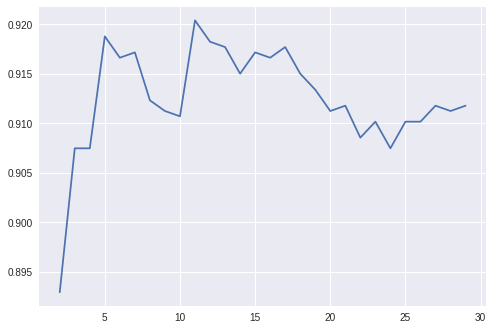

In [333]:
plt.plot(gs_res_df['param_n_neighbors'], gs_res_df['mean_test_score'])
plt.show()

Scores pretty well on the test data as well

In [334]:
gs.score(X_test, y_test)

0.88259109311740891

Our best model uses 11 neighbors as its optimal parameter for category classification

In [335]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='uniform')

Lets store this model so we can use it later to predict new categories for given articles.

In [336]:
from sklearn.externals import joblib
joblib.dump(gs.best_estimator_, 'model.p')

['model.p']

Lets make a suite of functions to help predict the category of an article given its text using the prediction model we made

In [338]:
from urllib.parse import urlparse

In [354]:

def title_text_from_url(url):
    '''get the title and text of an article from its url'''
    
    url = urlparse(url)
    path=url.path
    
    title=path.split("/wiki/")[-1]
    text=get_text(title)
    
    return (title, text)
    

In [355]:
ml_text=text_from_url('https://en.wikipedia.org/wiki/Machine_learning')
ml_text[1][:100]

'machine learning is the subfield of computer science that according to arthur samuel gives computers'

In [356]:

def vectorize_text(text):  
    '''vectorize the text using the same 
    tfidf_vectorizer and SVD from the model'''
    
    search_term_vec = tfidf_vectorizer.transform([text])
    search_term_lsa = SVD.transform(search_term_vec)
    
    return search_term_lsa
    

In [358]:

def category_prediction(url):
    '''make a category prediction using the text
      of an article return the category prediction
      and how likely the prediction is correct'''
    
    title, text=title_text_from_url(url)
   
    search_vector=vectorize_text(text)
    
    model = joblib.load('model.p') 
    pred=model.predict(search_vector)[0]
    
    if pred==0:
        prob=model.predict_proba(search_vector)[0][0]*100
    else:
        prob=model.predict_proba(search_vector)[0][1]*100
        
    if pred==0:
        pred='Business Software'
    else:
        pred='Machine Learning'
        
    return "It's {}% likely {} is a {} type of article".format(np.round(prob, 2), title, pred)

In [359]:
category_prediction('https://en.wikipedia.org/wiki/Machine_learning')

"It's 100.0% likely Machine_learning is a Machine Learning type of article"

In [360]:
category_prediction("https://en.wikipedia.org/wiki/Binary_number")

"It's 92.31% likely Binary_number is a Machine Learning type of article"

Lets test a bunch of Articles

In [347]:
binary_number="https://en.wikipedia.org/wiki/Binary_number"
lda="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation"
markov_model="https://en.wikipedia.org/wiki/Markov_model"
quickbooks="https://en.wikipedia.org/wiki/QuickBooks"
turbo_tax="https://en.wikipedia.org/wiki/TurboTax"
elon_musk="https://en.wikipedia.org/wiki/Elon_Musk"
mark_cuban="https://en.wikipedia.org/wiki/Mark_Cuban"
donald_trump="https://en.wikipedia.org/wiki/Donald_Trump"
microsoft_paint="https://en.wikipedia.org/wiki/Microsoft_Paint"
clustering="https://en.wikipedia.org/wiki/Cluster_analysis"
rick_and_morty="https://en.wikipedia.org/wiki/Rick_and_Morty"

test_urls=[binary_number, lsa, markov_model, quickbooks, turbo_tax, elon_musk,\
           mark_cuban, donald_trump, microsoft_paint, clustering, rick_and_morty]

In [361]:
results=[category_prediction(url) for url in test_urls]

In [362]:
pprint.pprint(results)

["It's 92.31% likely Binary_number is a Machine Learning type of article",
 "It's 96.15% likely Latent_semantic_analysis is a Machine Learning type of "
 'article',
 "It's 88.46% likely Markov_model is a Machine Learning type of article",
 "It's 50.0% likely QuickBooks is a Business Software type of article",
 "It's 53.85% likely TurboTax is a Business Software type of article",
 "It's 65.38% likely Elon_Musk is a Business Software type of article",
 "It's 80.77% likely Mark_Cuban is a Business Software type of article",
 "It's 69.23% likely Donald_Trump is a Business Software type of article",
 "It's 57.69% likely Microsoft_Paint is a Business Software type of article",
 "It's 100.0% likely Cluster_analysis is a Machine Learning type of article",
 "It's 61.54% likely Rick_and_Morty is a Business Software type of article"]
